In [7]:
import numpy as np
from random import randrange
import matplotlib.pyplot as plt
%matplotlib inline
import PIL.Image
import pandas as pd
import seaborn as sns
pd.options.mode.chained_assignment = None  # default='warn'

from functions.genome_topology import open_pdb
from functions.genome_topology import select_chrom
from functions.genome_topology import geom_distance
from functions.genome_topology import fractal_dimension
from functions.genome_topology import get_matrix
import scipy
import scipy.stats as ss

from functions.statistical_analysis import comparison_distributions
from functions.statistical_analysis import correlate
from functions.plotting_tools import set_layout

from pylab import show
from math import sqrt
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D

In [3]:
#Simulate Brownian in a box
def BrownianInBox (start, N_steps, step, size):
    k=0
    while k <N_steps:
        
        x = coords[k-1, 0]
        y = coords[k-1, 1]
        z = coords[k-1, 2]
        
        opt=np.zeros((6,3))
        
        opt[0,:] = [x - step, y, z]
        opt[1,:] = [x, y + step, z]
        opt[2,:] = [x + step, y, z]
        opt[3,:] = [x, y - step, z]
        opt[4,:] = [x, y, z + step]
        opt[5,:] = [x, y, z - step]
        
        direction = randrange((6))
        new_position = opt[direction, :]
        
        comparison = (new_position == coords[k-2,:]).all()

        if ((np.abs(new_position) != size).all() and comparison == False):
            coords[k,:]=new_position
            k = k + 1
    return coords
        
#Assemble dataframe with fractal dimension from high, low clustering, and random chains  
def make_fractalD_df(df, fractal_random, number_of_contacts, norm = True):
    if norm:
        fractal_chromosome = 'Norm Fractal dimension'
        fractal_simulation=np.copy(fractal_random/number_of_contacts)
    else:
        fractal_chromosome = 'Fractal dimension'
        fractal_simulation=np.copy(fractal_random)
        
    length_dataframe= len(fractal_simulation)
    Clustering_array=['']*length_dataframe
    
    Clustering_array[0:number_of_chains]=['High clustering']*number_of_chains
    Clustering_array[0:number_of_chains]=['High clustering']*number_of_chains
    Clustering_array[number_of_chains:number_of_chains*2]=['Low clustering']*number_of_chains
    Clustering_array[number_of_chains*2:number_of_chains*3] = ['Random chain']*number_of_chains

    Fractal_dimension=np.zeros(length_dataframe*3)
    Fractal_dimension[0:number_of_chains]=np.copy(df_highclust[fractal_chromosome])
    Fractal_dimension[number_of_chains:number_of_chains*2]=np.copy(df_lowclust[fractal_chromosome])
    Fractal_dimension[number_of_chains*2:number_of_chains*3]= fractal_simulation

    fractal_dimension_df={'Fractal dimension':Fractal_dimension, 'Dataset':Clustering_array }
    fractal_dimension_df=pd.DataFrame(fractal_dimension_df)
    
    return fractal_dimension_df

# RANDOM CHAIN SIMULATION

In this notebook we simulate the folding of a random chain, by simulating a random walk on a grid, constrained in a box. Box and number of steps are chosen starting from parameters retrieved from 3D structures of chromosomes (x/y/z extension, number of particles). We generate 80 random chains. 
Then, we calculate the topology matrix and the topological fractal dimension for these random chains. We normalize the fractal dimension by number of contacts.
The normalized fractal dimension of the random chains is then compared to that of the chromosomes from high and low clustering groups.

Load data from all cells and structural information from chromosomes

In [5]:
df=pd.read_excel('data/data_allcells.xlsx')
structural_info=pd.read_csv('data/Structural_info.csv')
N_steps=structural_info['N atoms']
X=structural_info['X size']
Y=structural_info['Y size']
Z=structural_info['Z size']
GyR=structural_info['Gyration radius']

#Normalize fractal dimension
df['Norm Fractal dimension']= df['Fractal dimension']/df['n atoms']

#Divide dataset into high and low clustering dataframes
df_highclust=df[(df['cell']==1)|(df['cell']==4)|(df['cell']==6)|(df['cell']==8)]
df_lowclust=df[(df['cell']==2)|(df['cell']==3)|(df['cell']==5)|(df['cell']==7)]
radius_chrom = df['Rg']

#Parameters simulation
r_cutoff= 0.9
neighbours=1
step = 1

Random walk simulation. Choose:
- the repeat number of the simulation, not to overwrite previous data
- the number of chains you want to simulate

In [8]:
repeat=10
number_of_chains = 80
box_size=np.transpose(np.array([X//2,Y//2,Z//2]))
fractal_dim = np.zeros(number_of_chains)
r_coeff = np.zeros(number_of_chains)
number_of_contacts= np.zeros(number_of_chains)

for t in range(number_of_chains):
    start = [0, 0, 0]
    coords=np.zeros((int(N_steps[t]), 3))
    coords = BrownianInBox(start, N_steps[t], step, box_size[t,:])
    dist, n_contact, index=geom_distance(coords, r_cutoff, neighbours)
    number_of_contacts[t]=n_contact
    mat, psc = get_matrix(index, 'random')
    fractal_dim[t], r_coeff[t]=fractal_dimension(mat)

#Combine in the same database fractal dimension of random chains with fractal dimension of chromosomes
df_fractalD = make_fractalD_df(df, fractal_dim, number_of_contacts, norm = True)
print('Mean number of contacts: {}'.format(np.mean(number_of_contacts)))
print('Corr fractal dimension vs number of contacts {}'.format(correlate(fractal_dim, number_of_contacts)))

Mean number of contacts: 336.6625
Corr fractal dimension vs number of contacts ('0.40', '2.3E-04')


Compare distributions of (normalized) fractal dimension for random chain, high and low clustering chromosomes

the distributions are not normal: 8.060204947923921e-08, 1.8674297663778816e-08
The distributions do not have equal variance: 6.521258685871433e-07
Kolmogorov test: False = 1.4556338406352406e-41
the distributions are not normal: 2.1441650460474193e-05, 1.8674297663778816e-08
The distributions do not have equal variance: 1.8216768108075475e-07
Kolmogorov test: False = 3.476555626069359e-45
4 points were omitted from the plot


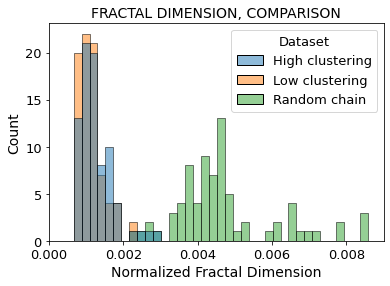

In [9]:
#Plot distributions
set_layout()
axis_lim=0.009
sns.histplot(data=df_fractalD, x='Fractal dimension', hue='Dataset', bins=60)
plt.xlim(0.0, axis_lim)
out_of_axis = df_fractalD[df_fractalD['Fractal dimension']> axis_lim]
n_out_of_axis=len(out_of_axis)
plt.xlabel('Normalized Fractal Dimension')
plt.title('FRACTAL DIMENSION, COMPARISON')

#Comparison high clustering and simulated fractal dimension
dist1= df_fractalD[df_fractalD['Dataset']=='High clustering']['Fractal dimension']
dist2= df_fractalD[df_fractalD['Dataset']=='Random chain']['Fractal dimension']
path='results/fractal dimension/norm_fractal_dimension_highvssim{}'.format(repeat)

test_results= comparison_distributions(dist1, dist2, path_results=path)

#Comparison low clustering and simulated fractal dimension
dist1= df_fractalD[df_fractalD['Dataset']=='Low clustering']['Fractal dimension']
dist2= df_fractalD[df_fractalD['Dataset']=='Random chain']['Fractal dimension']
path='results/fractal dimension/norm_fractal_dimension_lowvssim{}'.format(repeat)

test_results= comparison_distributions(dist1, dist2, path_results=path)

print('{} points were omitted from the plot'.format(n_out_of_axis))

#Save figures
#plt.savefig('results/figures/fractaldimension_comparison.jpg', bbox_inches='tight')
#plt.savefig('results/figures/fractaldimension_comparison{}.eps'.format(repeat), bbox_inches='tight')

Compare distributions fractal dimension for chromosomes, high and low clustering

In [12]:
#Comparison high and low clustering fractal dimension
dist1= df_fractalD[df_fractalD['Dataset']=='High clustering']['Fractal dimension']
dist2= df_fractalD[df_fractalD['Dataset']=='Low clustering']['Fractal dimension']
#path='results/fractal dimension/norm_fractal_dimension_highvssim{}'.format(repeat)
test_results= comparison_distributions(dist1, dist2)

#Mean distributions
mean1=np.mean(dist1)
sd1=np.std(dist1)/np.sqrt(len(dist1))
print('High clustering: {} +- {}'.format(mean1, sd1))

mean2=np.mean(dist2)
sd2=np.std(dist2)/np.sqrt(len(dist2))
print('High clustering: {} +- {}'.format(mean2, sd2))

the distributions are not normal: 8.060204947923921e-08, 2.1441650460474193e-05
The distributions have equal variance: 0.36029286507845193
Mannwhitneyu test: False = 0.022669237111055954
High clustering: 0.0012526520309164596 +- 4.59032101272025e-05
High clustering: 0.0011303561492620924 +- 3.800089908842586e-05


Plot random walk: 2D projection and 3D plot and topology matrix 

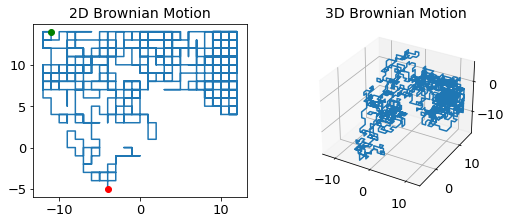

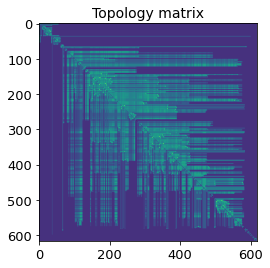

In [75]:
fig = plt.figure(1, figsize = (13, 7)) #prepare plot
ax2 = fig.add_subplot(231)

#Extract random chain
coords = BrownianInBox(start, N_steps[t], step,  box_size[t,:])
#Calculate topology
dist, n_contact, index=geom_distance(coords, r_cutoff, neighbours)
mat, psc = get_matrix(index, 'random')

#Make plot
fig = plt.figure(1, figsize = (13, 7)) #prepare plot

ax2 = fig.add_subplot(231)
ax2.plot(coords[:,0],coords[:,1])
ax2.plot(coords[0,0],coords[0,1], 'go') #begin
ax2.plot(coords[-1,0], coords[-1,1], 'ro') #end
ax2.set_title('2D Brownian Motion')

xdata=coords[:,0] 
ydata=coords[:,1]
zdata=coords[:,2]

ax = fig.add_subplot(2, 3, 2, projection='3d')
ax.plot3D(xdata, ydata, zdata)
ax.set_title('3D Brownian Motion')

#Save figure
#plt.savefig('results/figures/3Dbrownian3.png')

plt.figure()
plt.title('Topology matrix')
plt.imshow(mat)

#Save figure
#PIL.Image.fromarray(mat.astype(float)).save("results/figures/topology_random.tif")